In [ ]:
%%capture
!pip install transformers
!pip install sentencepiece

**IMPORTING**

In [ ]:
#importing the necessary libraries

import re
import spacy
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, BertTokenizer, DistilBertTokenizer
from torch.utils.data import TensorDataset
from transformers  import BertForSequenceClassification, AutoModel, AutoModelForSequenceClassification, DistilBertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TextClassificationPipeline

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
#df = pd.read_csv("/content/train.csv")
#df.shape

**TEXT PREPROCESSING**

In [ ]:
#Reading in the training and testing files
train_df = pd.read_csv("/content/drive/MyDrive/Otherweb/Dataset versions/final_topic_gt_100_plus_adjustment_dataset.csv")
train_df.head()

,article_text,topic
0,Secretary of Homeland Security Alejandro Mayor...,Federal Policies
1,The logo of cryptocurrency exchange Binance di...,Crypto Trading
2,Prince Harry fell off his horse in front of hi...,Royalty
3,"Police officers, some in riot gear, guard a gr...",Social Issues
4,Americans at nearly every rung of the economic...,Personal Finance / Financial Education


In [ ]:
train_df.shape

(27910, 2)

In [ ]:
#renaming the columns
train_df.rename(columns={"article_text": "Text", "topic": "Category"}, inplace=True)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased",
                                                do_lower_case=True
                                                )

def chunker(text, tokenizer, sep='\n', max_len=512):
    """Split long text into chunks"""
    # Split into sentences
    sentences = []
    spacy_doc = nlp(text)

    for sent in spacy_doc.sents:
      sentences.append(str(sent))
    # Drop empty sentences
    sentences = [s for s in sentences if len(s.strip())]
    # Compute token lengths
    lens = [len(t) for t in tokenizer(sentences, return_attention_mask=False, return_tensors="pt", truncation=True, padding=True)['input_ids']]

    chunks, clen = [[]], 0
    for i, l in enumerate(lens):
        if clen+l <= max_len:
            chunks[-1].append(i)
            clen += l
        else:
            chunks.append([i])
            clen = l

    paragraphs = [sep.join(sentences[i] for i in chunk) for chunk in chunks]
    return paragraphs

In [ ]:
new_data = pd.DataFrame(columns=["Text", "Category"])

In [ ]:
for i in range(train_df.shape[0]):
  article = train_df.iloc[i]["Text"]
  label = train_df.iloc[i]["Category"]

  chunks = chunker(article, tokenizer)
  #chunks = chunks[1:]

  for chunk in chunks:
    new_data = new_data.append({"Text":chunk, "Category":label}, ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-10-352b6624cf8e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append({"Text":chunk, "Category":label}, ignore_index=True)
<ipython-input-10-352b6624cf8e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append({"Text":chunk, "Category":label}, ignore_index=True)
<ipython-input-10-352b6624cf8e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append({"Text":chunk, "Category":label}, ignore_index=True)
<ipython-input-10-352b6624cf8e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append({"

In [ ]:
train_df = new_data

In [ ]:
train_df.shape

(27910, 2)

In [ ]:
#Dropping null values
train_df = train_df.dropna(axis=0)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train_df['Category'].value_counts()

US Congress Politics                             1127
Social Issues                                     939
Europe Politics                                   910
Gaming and Entertainment                          741
Biology                                           704
                                                 ... 
Pets                                              109
International Culture                             108
Writing & Literature                              104
US Involvement in International Organizations     101
Writing and Literature                             77
Name: Category, Length: 87, dtype: int64

In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [ ]:
#Getting all unique classes from the training_set
possible_labels = train_df["Category"].unique()

#Generating a dict where every class map to an id
label_dict = {}
for index, possible_label in enumerate(possible_labels):
  label_dict[possible_label] = index

In [ ]:
#Adding the numerical labels into the datafram
train_df["label"] = train_df["Category"].replace(label_dict)

Text(0.5, 1.0, 'Category Count')

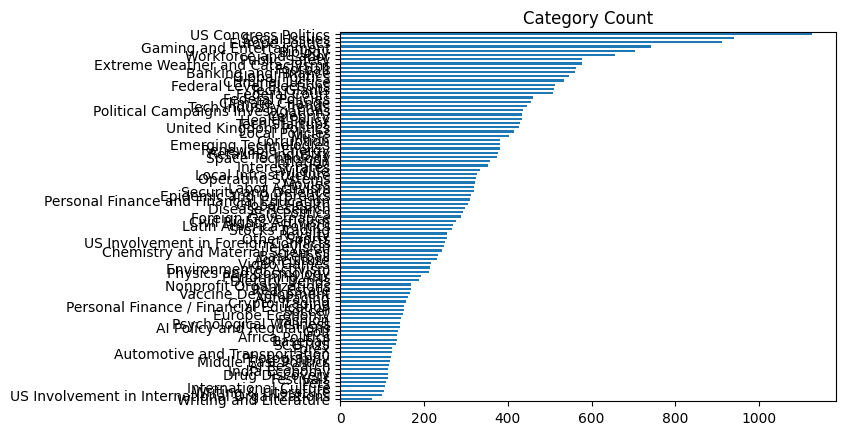

In [ ]:
#Distribution of training data per class

train_df["Category"].value_counts(ascending=True).plot.barh()
plt.title("Category Count")

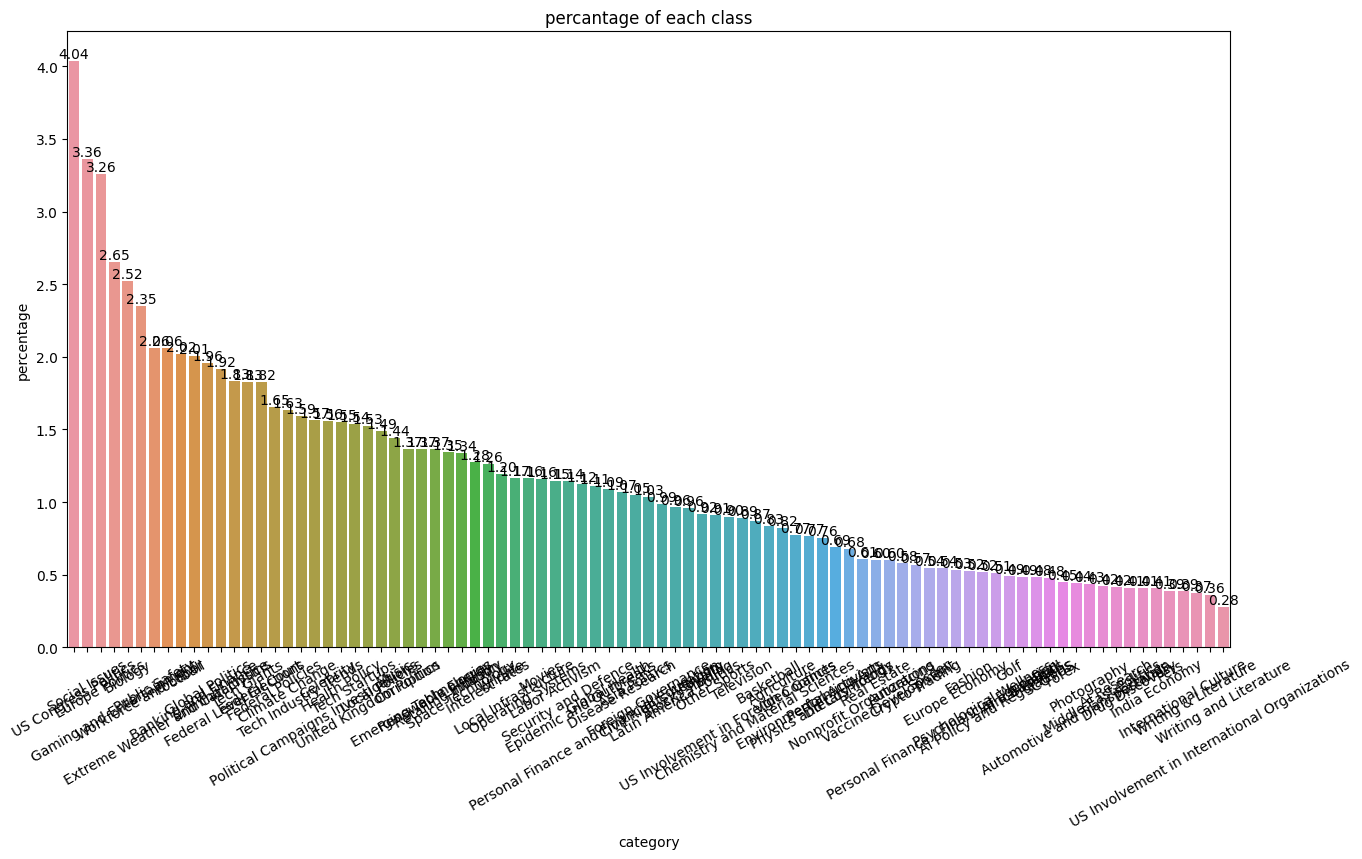

In [ ]:
#Get the percentage of the whole class in the training set

category_percentage = (100*train_df.Category.value_counts()/len(train_df)).to_frame().reset_index()
category_percentage.columns = ["category", "percentage"]

#visualize the output
plt.figure(figsize=(15,8))
chart = sns.barplot(x="category", y="percentage", data=category_percentage)
chart.set_title("percantage of each class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)

for p in chart.patches:
  chart.annotate("%0.2f"% p.get_height(), (p.get_x() + p.get_width()/2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black',xytext=(0,5),
                 textcoords= "offset points")

In [ ]:
#Getting to know the number of tokens in each class
train_df['#tokens'] = train_df['Text'].apply(lambda x: len(x.split()))

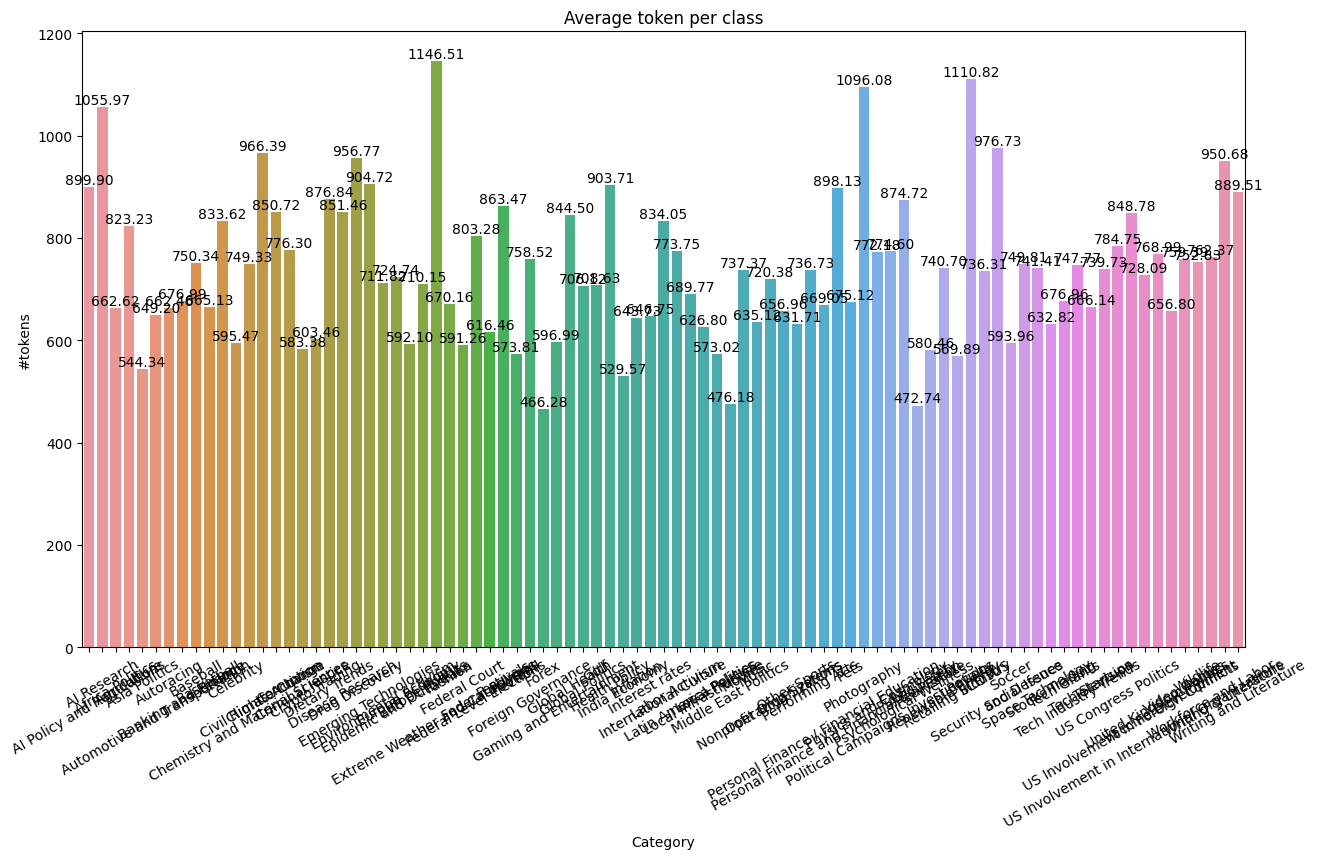

In [ ]:
#Let us visaulize the average number of tokens for each class

avg_tokens_per_cat = train_df.groupby('Category')['#tokens'].mean().to_frame().reset_index()
#visualize the result
plt.figure(figsize=(15,8))
chart = sns.barplot(x="Category", y="#tokens",data = avg_tokens_per_cat)
chart.set_title("Average token per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)

for p in chart.patches:
  chart.annotate("%0.2f" % p.get_height(), (p.get_x() + p.get_width()/ 2., p.get_height()),
                 ha="center", va='center', fontsize=10, color='black',xytext=(0,5),
                 textcoords = "offset points")


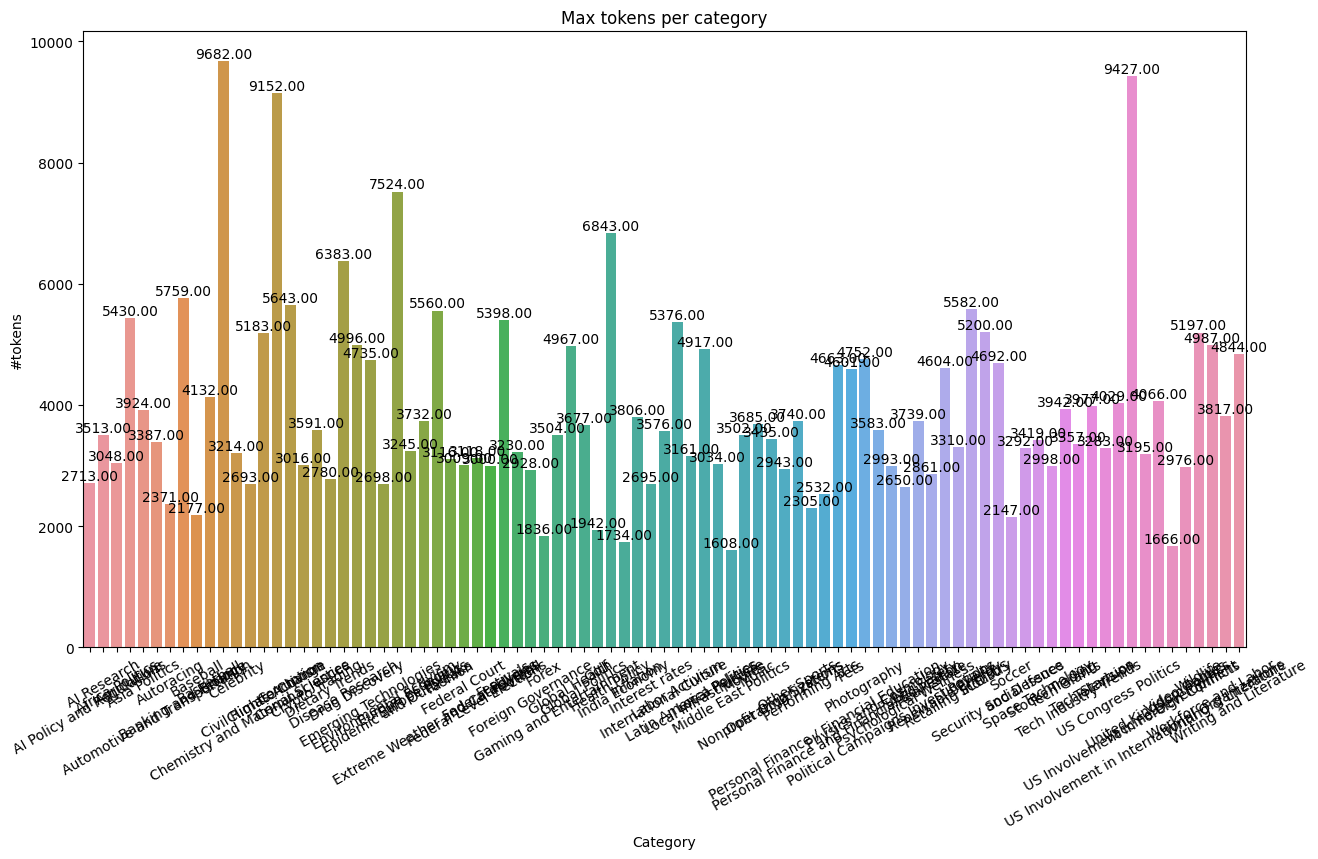

In [ ]:
#Generating the maxmimum tokens per each class

max_tokens_per_cat = train_df.groupby('Category')['#tokens'].max().to_frame().reset_index()
#visualize result
plt.figure(figsize=(15,8))
chart = sns.barplot(x='Category', y='#tokens',data=max_tokens_per_cat)
chart.set_title("Max tokens per category")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)

for p in chart.patches:
  chart.annotate("%0.2f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height()),
                  ha='center', va="center", fontsize=10, color="black",xytext=(0,5),
                  textcoords = "offset points")

Text(0.5, 0, '')

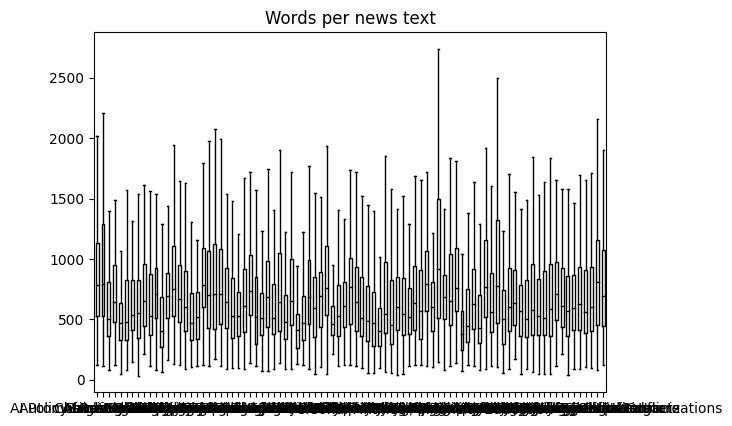

In [ ]:

#Distribution of words per text

train_df['Words per news text'] = train_df['Text'].str.split().apply(len)
train_df.boxplot('Words per news text', by='Category', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")

In [ ]:
train_df.head()

,Text,Category,label,#tokens,Words per news text
0,Rep. Bennie Thompson indicated it's up to the ...,US Congress Politics,0,444,444
1,"TAMPA, Fla. — Voyager Space is considering usi...",Space Technology,1,564,564
2,"Good morning, and happy Tuesday!\nToday we’re ...",Tech Startups,2,469,469
3,Some people arriving in the UK in small boats ...,United Kingdom Politics,3,448,448
4,Schools are offering pupils in non-exam years ...,United Kingdom Politics,3,1631,1631


In [ ]:
#splitting the dataset into training and testing set
x_train, x_val, y_train, y_val = train_test_split(train_df.index.values,
                                                  train_df.label.values,
                                                  test_size=0.1,
                                                  random_state=42,
                                                  stratify = train_df.label.values
                                                  )

#specify the datatype

train_df['data_type'] = ['not_set']*train_df.shape[0]
train_df.loc[x_train, 'data_type'] = 'train'
train_df.loc[x_val, 'data_type'] = 'val'

train_df.groupby(['Category', 'label', 'data_type']).count()


Text  #tokens  Words per news text
Category                  label data_type                                    
AI Policy and Regulations 59    train       129      129                  129
                                val          14       14                   14
AI Research               77    train       104      104                  104
                                val          12       12                   12
Africa Politics           22    train       122      122                  122
...                                         ...      ...                  ...
Workforce and Labor       57    val          65       65                   65
Writing & Literature      10    train        94       94                   94
                                val          10       10                   10
Writing and Literature    86    train        69       69                   69
                                val           8        8                    8

[174 rows x 3 columns]

**MODELLING**

In [ ]:
#labels = ["Politics", "Business", "Health", "Sports", "Tech", "World", "Science", "Entertainment"]

In [ ]:
#initialize a distillbert tokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased",
                                                do_lower_case=True
                                                )

#Encode the training dataset
encoded_data_train = tokenizer.batch_encode_plus(
    train_df[train_df.data_type == 'train'].Text.values,
    add_special_tokens=True,
    return_attention_mask = True,
    padding='max_length',
    truncation = True,
    max_length = 512,
    return_tensors = 'pt',)

#encoding the val dataset
encoded_data_val = tokenizer.batch_encode_plus(
    train_df[train_df.data_type == 'val'].Text.values,
    add_special_tokens=True,
    return_attention_mask =True,
    padding = 'max_length',
    truncation = True,
    max_length = 512,
    return_tensors = 'pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_mask_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df[train_df.data_type == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_mask_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(train_df[train_df.data_type == 'val'].label.values)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
#intansiate a distilbert model

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                            num_labels = len(label_dict),
                                                            output_attentions=False,
                                                            output_hidden_states = False)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Prepare tensor datasets

dataset_train = TensorDataset(input_ids_train, attention_mask_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_mask_val, labels_val)

In [ ]:
batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

dataloader_validation = DataLoader(dataset_val,
                             sampler = RandomSampler(dataset_val),
                             batch_size = batch_size)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 10
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
#Getting the f1_score of the class
def f1_score_func(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted')

#Getting the accuracy per each class
def accuracy_per_class(preds, labels):
  label_dict_inverse = {v:k for k, v in label_dict.items()}
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat == label]
    y_true = labels_flat[labels_flat == label]
    print(f'Class: {label_dict_inverse[label]}')

    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
#seeding all

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
#connecting to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
def evaluate(dataloader_val):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []

  for batch in dataloader_val:
    batch = tuple(b.to(device) for b in batch)

    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]
              }
    with torch.no_grad():
      outputs = model(**inputs)

    loss = outputs[0]
    logits = outputs[1]
    loss_val_total += loss.item()

    logits = logits.detach().cpu().numpy()
    labels_ids = inputs['labels'].cpu().numpy()
    predictions.append(logits)
    true_vals.append(labels_ids)

  loss_val_avg = loss_val_total/len(dataloader_val)
  predictions  = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs +1)):
  model.train()

  loss_train_total = 0
  progress_bar = tqdm(dataloader_train, desc = 'Epoch {:1d}'.format(epoch), leave=False, disable=False)

  for batch in progress_bar:
    model.zero_grad()

    batch =  tuple(b.to(device) for b in batch)

    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]
        }

    outputs = model(**inputs)

    loss = outputs[0]
    loss_train_total += loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

    progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

  torch.save(model.state_dict(), f'finetuned_distilBERT_epoch_{epoch}.model')

  tqdm.write(f'\nEpoch {epoch} ')

  loss_train_avg = loss_train_total/len(dataloader_train)

  tqdm.write(f'Training loss: {loss_train_avg}')

  val_loss, predictions, true_vals = evaluate(dataloader_validation)
  val_f1 = f1_score_func(predictions, true_vals)
  tqdm.write(f'Validation loss: {val_loss}')
  tqdm.write(f'F1 score(weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 1 
Training loss: 2.231292626101185
Validation loss: 1.3986633729857865
F1 score(weighted): 0.5851629760776514


Epoch 2:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 2 
Training loss: 1.1710242083485047
Validation loss: 1.2366799632873622
F1 score(weighted): 0.6530045142284897


Epoch 3:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 3 
Training loss: 0.903730977151668
Validation loss: 1.3158536366368099
F1 score(weighted): 0.6720556271354264


Epoch 4:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 4 
Training loss: 0.7505401495318457
Validation loss: 1.4433710376054816
F1 score(weighted): 0.6803243632795858


Epoch 5:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 5 
Training loss: 0.6113342463463994
Validation loss: 1.6287832996927034
F1 score(weighted): 0.6827164737475281


Epoch 6:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 6 
Training loss: 0.49368347714308974
Validation loss: 1.8120301774968746
F1 score(weighted): 0.6899560852602481


Epoch 7:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 7 
Training loss: 0.3993045683605893
Validation loss: 1.9514017865729976
F1 score(weighted): 0.691958381068267


Epoch 8:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 8 
Training loss: 0.3251348690480769
Validation loss: 2.0716207069779577
F1 score(weighted): 0.6928061944578149


Epoch 9:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 9 
Training loss: 0.2609345250211236
Validation loss: 2.1121171976083994
F1 score(weighted): 0.6915484858662059


Epoch 10:   0%|          | 0/8373 [00:00<?, ?it/s]


Epoch 10 
Training loss: 0.21229522649297036
Validation loss: 2.14921523435174
F1 score(weighted): 0.6964957860045228


In [ ]:

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                            num_labels = len(label_dict),
                                            output_attentions = False,
                                            output_hidden_states = False
                                            )

model.to(device)

model.load_state_dict(torch.load('/content/finetuned_distilBERT_epoch_9.model', map_location = torch.device('cpu')))
model.save_pretrained("finetuned_distilbert_news_article_categorization_model")
tokenizer.save_pretrained('finetuned_distilert_news_article_categorization_tokenizer')

_, predictions, true_vals = evaluate(dataloader_validation)
print(accuracy_per_class(predictions, true_vals))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class: US Congress Politics
Accuracy: 103/113

Class: Epidemic and Outbreaks
Accuracy: 12/17

Class: Public Safety
Accuracy: 41/58

Class: Security and Defence
Accuracy: 26/32

Class: Europe Politics
Accuracy: 63/91

Class: Extreme Weather and Cataclysms
Accuracy: 53/58

Class: Retailing Industry
Accuracy: 30/38

Class: Gaming and Entertainment
Accuracy: 70/74

Class: Vaccine Development
Accuracy: 14/17

Class: Europe Economy
Accuracy: 9/15

Class: US Involvement in International Organizations
Accuracy: 9/10

Class: Banking and Finance
Accuracy: 29/34

Class: Civil Rights Activism
Accuracy: 9/28

Class: Operating Systems
Accuracy: 18/19

Class: Television
Accuracy: 21/25

Class: Renewable Energy
Accuracy: 32/38

Class: United Kingdom Politics
Accuracy: 29/43

Class: Movies
Accuracy: 26/32

Class: Physics and Cosmology
Accuracy: 15/21

Class: Nonprofit Organizations
Accuracy: 16/17

Class: Drug Discovery
Accuracy: 7/11

Class: Social Issues
Accuracy: 68/94

Class: Pets
Accuracy: 9/11

C

**MODEL EVALUATION**

In [ ]:
#Let us predict on an unseen news
#abels = ['Entertainment', 'World','health', 'Politics', 'sport', 'Tech','Business', 'Science']
custom_news  = """CompaniesJOHANNESBURG, Dec 12 (Reuters) - Aspen Pharmacare (APNJ.J) has wrapped up pacts to secure funding of $30 million from the Gates Foundation and the Coalition for Epidemic Preparedness Innovations to help make affordable vaccines for Africa, the company said on Monday.In August, Aspen announced a deal with the Serum Institute of India to make and sell four Aspen-branded vaccines for Africa, as it looks to use its near-idle COVID-19 vaccine production lines in South Africa.It had been negotiating with the two organizations for grant funding.\"The new funding from CEPI and the Gates Foundation will support a ten-year agreement between Aspen and Serum Institute that aims to expand the supply and sourcing of affordable vaccines manufactured in Africa,\" the company said.[1/2] People wearing face masks walk past a logo of South African pharmaceutical major Aspen Pharmacare, at its Johnson & Johnson COVID-19 vaccine facility in Gqeberha, South Africa, October 25, 2021. REUTERS/Siphiwe SibekoEach of the two will contribute $15 million.The Serum Institute agreement provides for Aspen to make and distribute pneumococcal, rotavirus, polyvalent meningococcal and hexavalent vaccines commonly administered in Africa.It gives Aspen certainty on volumes, which will eventually more than cover an expected fall in revenue from its COVID vaccine contract with Johnson & Johnson (JNJ.N), Chief Executive Stephen Saad said in August.On Monday, Aspen said the funding, in addition to supporting the \"technology transfer activities\" set to begin early in 2023, will help sustain its regional vaccine making capacity against future outbreaks.Reporting by Nqobile Dludla; Editing by Louise Heavens and Clarence FernandezOur Standards: The Thomson Reuters Trust Principles.
"""
input_tensor = tokenizer.encode(custom_news, return_tensors='pt', truncation=True).to('cuda')
logits = model(input_tensor).logits
logits

tensor([[-0.5204, -1.1236, -1.4496, -1.0543, -2.7912,  2.5533, -1.5055,  2.7619,
         -0.5509,  0.6394,  1.3768]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
#compute probability from logits classification model outputs
softmax = torch.nn.Softmax(dim=1)
probs = softmax(logits)[0]
probs = probs.cpu().detach().numpy()
probs

array([8.6291262e-04, 9.1996014e-01, 2.8198119e-03, 2.2634417e-03,
       1.5768679e-03, 5.6919442e-03, 6.1743766e-02, 5.0810301e-03],
      dtype=float32)

Text(0, 0.5, 'Class probability (%)')

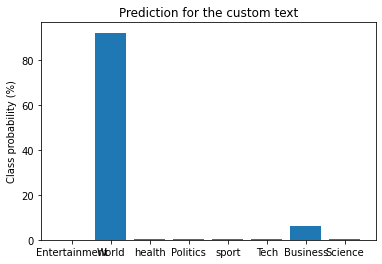

In [ ]:
#visualizing the probability of each class

plt.bar(labels, 100*probs, color='C0')
plt.title('Prediction for the custom text')
plt.ylabel("Class probability (%)")

In [ ]:
#connecting to my hugging face account
#hide_output
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#loading the model and tokenizer to valurank hugging face space
model.push_to_hub('finetuned-distilbert-topic_classification')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/abdulmatinomotoso/finetuned-distilbert-topic_classification/commit/051a3cdc42937b058e211a6673b2d98ba53c7699', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='051a3cdc42937b058e211a6673b2d98ba53c7699', pr_url=None, pr_revision=None, pr_num=None)